DETECTING FAKE NEWS STATEMENTS

In [2]:
#import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from imblearn.over_sampling  import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report




In [3]:
#read data with pandas
news_df = pd.read_csv('../Downloads/NEWS_STATEMENTS.csv')
news_df.head()

,Author,News_statement,Source,Validity_Check
0,Andy Nguyen,"The ocean is ""flat"" and ""contained"" by land fe...",Facebook posts,Fake
1,Jeff Cercone,"""Healthy pilots are suffering from myocarditis...",Instagram posts,Fake
2,Tom Kertscher,"“Face masks may raise risk of stillbirths, tes...",Instagram posts,Fake
3,Sara Swann,“When fentanyl burns it smells like popcorn.”,Facebook posts,Fake
4,Loreben Tuquero,Chick-fil-A “donates another $1.8 million to a...,Instagram posts,Fake


In [4]:
#function to encode the validity check column
def encode(column):
    encoded_column = []
    for value in column:
        if value == 'Fake':
            encoded_column.append(0)
        else:
            encoded_column.append(1)

    return encoded_column

In [5]:
#add the encoded values as column to the data frame
news_df['Validity_check'] = encode(news_df['Validity_Check'])
#drop the column that was encoded
news_df.drop(['Validity_Check'], axis = 1, inplace = True)

In [6]:
news_df.head()

,Author,News_statement,Source,Validity_check
0,Andy Nguyen,"The ocean is ""flat"" and ""contained"" by land fe...",Facebook posts,0
1,Jeff Cercone,"""Healthy pilots are suffering from myocarditis...",Instagram posts,0
2,Tom Kertscher,"“Face masks may raise risk of stillbirths, tes...",Instagram posts,0
3,Sara Swann,“When fentanyl burns it smells like popcorn.”,Facebook posts,0
4,Loreben Tuquero,Chick-fil-A “donates another $1.8 million to a...,Instagram posts,0


<AxesSubplot:xlabel='Validity_check', ylabel='count'>

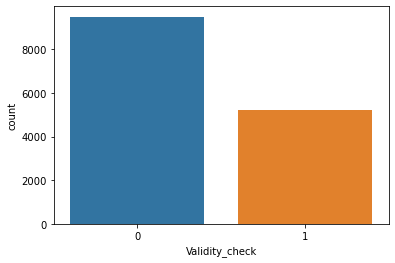

In [7]:
sns.countplot(x = news_df['Validity_check'])

There is an imbalance in the Target values(Validity check).

A solution to this would be to oversample the minority values in the column.

In [8]:
#split data into input and target variable
X = (news_df['News_statement']).values.reshape(-1, 1)
y = (news_df['Validity_check']).values.reshape(-1, 1)

In [9]:
#oversample the dataset
oversample = RandomOverSampler(sampling_strategy='not majority')
x_sampled, y_sampled = oversample.fit_resample(X, y)

X = x_sampled
y = y_sampled

In [10]:
#check for the oversampling done by counting the classes present after oversampling the column
print(sorted(Counter(y).items()))

[(0, 9483), (1, 9483)]


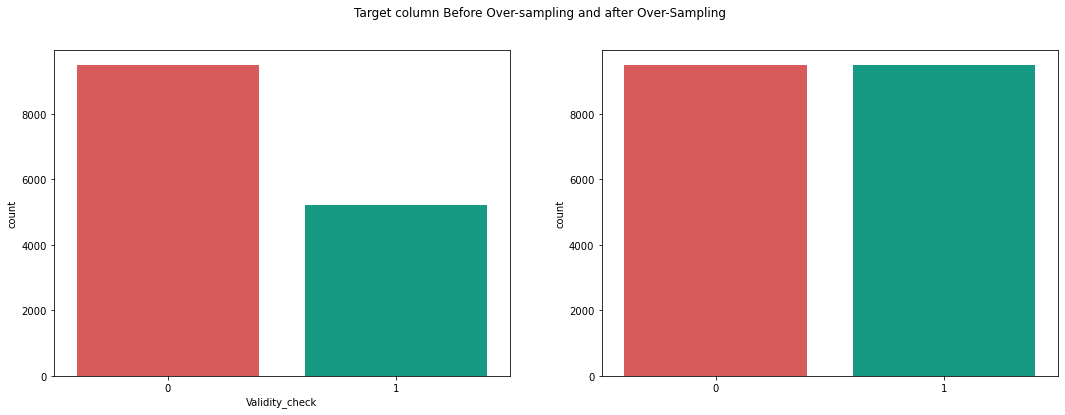

In [11]:
#visualize the oversampling results
plt.figure(figsize=(18,6))
plt.suptitle('Target column Before Over-sampling and after Over-Sampling')
plt.subplot(1,2,1)
sns.countplot(x = news_df['Validity_check'], palette=['#ec4646','#00af91'])
plt.subplot(1,2,2)
sns.countplot(y, x = 'Validity_check', palette=['#ec4646','#00af91'] )
plt.show()

splitting the data into training, validation, and test sets before preprocessing it to avoid data leakage.

In [15]:
# Split the data into training, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.15, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1765, random_state=42)


In [16]:
# print the shapes of the resulting datasets
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)
print('--------------------------------------------------')
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (13275, 1)
Validation data shape: (2846, 1)
Test data shape: (2845, 1)
--------------------------------------------------
Train labels shape: (13275,)
Validation labels shape: (2846,)
Test labels shape: (2845,)


Now that the data has been split, it's time to preprocess it.

To avoid repetition of lines of codes, Functions will be written for some of the preprocessing

In [17]:
#function to clean (standardize) data by removing extraneous characters making it easier to tokenize
def clean_data(data):
    cleaned = []
    for word in data:
        #Convert to lowercase
        word = str(word).lower()
        #get rid of urls
        word = re.sub('https?://\S+|www\.\S+', '', word)
        # get rid of non words and extra spaces
        word = re.sub('\\W', ' ', word)
        word = re.sub('\n', '', word)
        word = re.sub(' +', ' ', word)
        word = re.sub('^ ', '', word)
        word = re.sub(' $', '', word)
        cleaned.append(word)
    return cleaned

In [18]:
#apply the function on the train, validation and test data
train_data = clean_data(train_data)
val_data = clean_data(val_data)
test_data = clean_data(test_data)

In [19]:

# Feature Extraction using CountVectorizer (bag-of-words representation)
vectorizer = CountVectorizer()
train_data = vectorizer.fit_transform(train_data)
test_data = vectorizer.transform(test_data)



##MODEL TRAINING


*models trainned:*

Naive-Bayes Classifier

Gradient Boosting Classifier

Random Forest Classifier

In [23]:
# Train the Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(train_data, train_labels)

# Predict on the test set
predictions = nb_classifier.predict(test_data)

# Evaluate the model
nb_accuracy = accuracy_score(test_labels, predictions)
nb_report = classification_report(test_labels, predictions)

print("Accuracy:", nb_accuracy)
print("Classification Report:")
print(nb_report)


Accuracy: 0.7652021089630932
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.69      0.75      1442
           1       0.73      0.84      0.78      1403

    accuracy                           0.77      2845
   macro avg       0.77      0.77      0.76      2845
weighted avg       0.77      0.77      0.76      2845



In [24]:
# Train the Gradient Boosting Classifier
gbm_classifier = GradientBoostingClassifier()
gbm_classifier.fit(train_data, train_labels)

# Predict on the test set
predictions = gbm_classifier.predict(test_data)

# Evaluate the model
gbm_accuracy = accuracy_score(test_labels, predictions)
gbm_report = classification_report(test_labels, predictions)

print("Accuracy:", gbm_accuracy)
print("Classification Report:")
print(gbm_report)

Accuracy: 0.6966608084358523
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.74      0.71      1442
           1       0.71      0.65      0.68      1403

    accuracy                           0.70      2845
   macro avg       0.70      0.70      0.70      2845
weighted avg       0.70      0.70      0.70      2845



In [25]:
# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_data, train_labels)

# Predict on the test set
predictions = rf_classifier.predict(test_data)

# Evaluate the model
rf_accuracy = accuracy_score(test_labels, predictions)
rf_report = classification_report(test_labels, predictions)

print("Accuracy:", rf_accuracy)
print("Classification Report:")
print(rf_report)

Accuracy: 0.8221441124780317
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1442
           1       0.80      0.86      0.83      1403

    accuracy                           0.82      2845
   macro avg       0.82      0.82      0.82      2845
weighted avg       0.82      0.82      0.82      2845



In [26]:
#create a dictionary for the models and accuracies
model_df = {
    'Model': [
    'nb_classifier',
    'gbm_Classifier',
    'rf_Classifier',
    ],

    'Accuracy(%)': [
        f"{nb_accuracy*100:.2f}",
        f"{gbm_accuracy*100:.2f}",
        f"{rf_accuracy*100:.2f}",
        ]
}


#create a dataframe from the dictionary
evaluation_metrics = pd.DataFrame(model_df)

evaluation_metrics



,Model,Accuracy(%)
0,nb_classifier,76.52
1,gbm_Classifier,69.67
2,rf_Classifier,82.21


In [27]:
# Convert the 'Accuracy(%)' column to float
evaluation_metrics['Accuracy(%)'] = evaluation_metrics['Accuracy(%)'].astype(float)

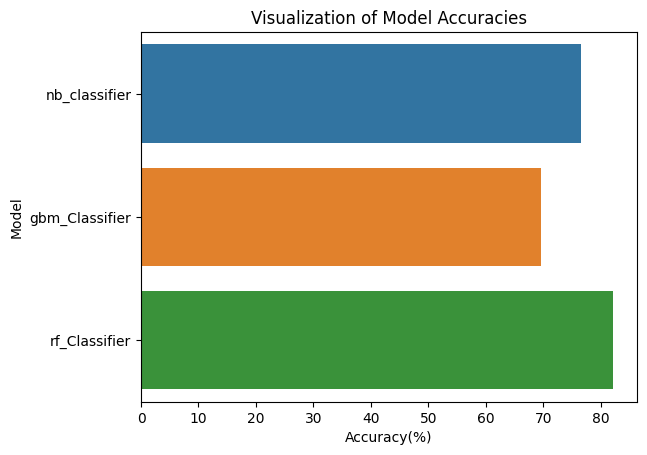

In [28]:
# Plot the model accuracies using a bar plot
sns.barplot(x='Accuracy(%)', y='Model', data=evaluation_metrics)

# Add labels and title
plt.xlabel('Accuracy(%)')
plt.ylabel('Model')
plt.title('Visualization of Model Accuracies')

# Show the plot
plt.show()